In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
from src.preprocessing import Clipper
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error
    , explained_variance_score
)
from sklearn.model_selection import (
    train_test_split
    , StratifiedKFold
    , cross_validate
)
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from hyperopt import fmin, hp, tpe, SparkTrials
from hyperopt.early_stop import no_progress_loss
import mlflow
import pyspark
from xgboost import XGBRegressor
import shap

shap.initjs()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

/usr/local/lib/python3.8/dist-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
wh = pd.read_csv("data/full_wh22.csv", index_col=0)
wh["year"] = wh["year"].astype(int)
wh.describe()

year  Life Ladder  Log GDP per capita  Social support  \
count  2089.000000  2089.000000         2089.000000     2089.000000   
mean   2013.727621     5.473747            9.379408        0.811830   
std       4.455614     1.115567            1.142248        0.118745   
min    2005.000000     2.178809            5.526723        0.290184   
25%    2010.000000     4.651972            8.475151        0.748287   
50%    2014.000000     5.405246            9.474574        0.835509   
75%    2017.000000     6.294282           10.345659        0.904694   
max    2021.000000     8.018934           11.665803        0.987343   

       Healthy life expectancy at birth  Freedom to make life choices  \
count                       2089.000000                   2089.000000   
mean                          63.232180                      0.745417   
std                            6.894532                      0.139767   
min                            6.720000                      0.257534   
25%                           59.150002                      0.654125   
50%                           64.959999                      0.766716   
75%                           68.400002                      0.856025   
max                           74.349998                      0.985178   

        Generosity  Perceptions of corruption  Positive affect  \
count  2089.000000                2089.000000      2089.000000   
mean      0.000229                   0.744287         0.651331   
std       0.158459                   0.182461         0.105448   
min      -0.335739                   0.035198         0.178886   
25%      -0.108066                   0.682109         0.570538   
50%      -0.021534                   0.794301         0.662436   
75%       0.088441                   0.867257         0.736459   
max       0.706377                   1.000000         0.883586   

       Negative affect  Confidence in national government      inflation  
count      2089.000000                        2089.000000    2089.000000  
mean          0.270514                           0.485211      75.493927  
std           0.085550                           0.186598    2853.924252  
min           0.082737                           0.068769     -72.730000  
25%           0.208130                           0.343268       1.557907  
50%           0.260324                           0.472183       3.416268  
75%           0.321357                           0.609015       6.920336  
max           0.704590                           1.000000  130060.200000

# Machine Learning Methods
In the previous notebook, we focused on the Pooled OLS regression, as this is the choice of the World Happiness Report. Then the results were compared and in the end R² of the report (from the year 2022) has been surpassed with 0.7904, where the report had it as 0.777. To push the boundaries more would not be fair, since we did not do separate the data to train, validation and test data. Here we will focus on improving the results by preventing leakage and will see how far we can go.

## Split the Data
As the year is a very important factor, at each dataset we should see at least a few the samples from each year. This means we cannot simply use random splitting, where some years might not even exist in train or test data. Therefore stratifying on the variable year is better suited for our purposes.

In [3]:
full_train_indexes, test_indexes = train_test_split(
    wh.index, test_size=0.15, random_state=10, stratify=wh.year
)

print("Train # of Rows:", full_train_indexes.shape[0])
print("Test # of Rows:", test_indexes.shape[0])

Train # of Rows: 1775
Test # of Rows: 314


As intended we have data from each year, distributed with the same ratio.

[]

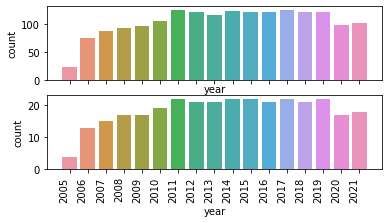

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True)
sns.countplot(
    data=wh.loc[full_train_indexes],
    x="year",
    ax=axes[0]
)
sns.countplot(
    data=wh.loc[test_indexes],
    x="year",
    ax=axes[1]
)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, horizontalalignment='right')
plt.plot()

## Short EDA for Preprocessing

From below graph, I could conclude that only Healthy life expectancy at birth has extreme outliers, but there are also the ones, which are not so extreme. They will be clipped to gain performance.

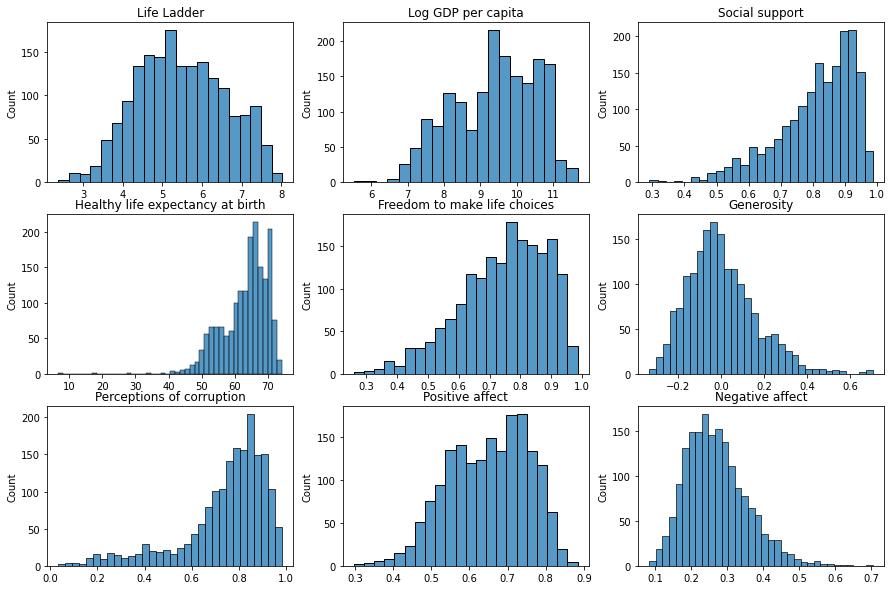

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(15,10))
axes = axes.flatten()
for ax, col in zip(axes, wh.drop(columns=["year", "Country name"]).columns):
    sns.histplot(wh.loc[full_train_indexes][col], ax = ax)
    ax.set_title(col)
    ax.set_xlabel("")

## Preprocessing
Below two pipelines are created for preprocessing, one for the independent variables and another one for the dependent one, happiness.

In [6]:
wh_clip_config = {
    "Healthy life expectancy at birth" : (40,None),
    "Log GDP per capita" : (6.5,None),
    "Social support" : (0.4,None),
    "Generosity" : (None,0.6),
    "Negative affect" : (None, 0.6)
}

In [7]:
preproc_X = Pipeline([
    ("clipper" , Clipper(wh_clip_config)), # clip the columns with the configuration
    ("col_transform", ColumnTransformer(
            [
                ( # Scale the data, except for years and two other columns
                    "scaler", StandardScaler(), 
                    wh.drop(columns=["Country name", "year", "Life Ladder"]).columns
                ),
                ("year_dummies", OneHotEncoder(), ["year"]), # Get the dummies for the year
            ]
        , remainder="drop" # The rest will be dropped, which is Country name
        )
    )
    
])

preproc_Y = Pipeline([
    ("scaler", StandardScaler()) # Scale the response variable
])

Let us run the pipelines!

In [8]:
train_X = preproc_X.fit_transform(wh.drop(columns=["Life Ladder"]).loc[full_train_indexes])
train_X = pd.DataFrame(train_X, columns = preproc_X.get_feature_names_out())
train_Y = preproc_Y.fit_transform(wh[["Life Ladder"]].loc[full_train_indexes])
train_Y = pd.Series(train_Y[:,0], name="Life Ladder")

## Model Training and Hyperparameter Search
Let us start model training! But first the metrics to consider are listed. Just like in the previous notebook, WHR22-Explaining-Happiness, we will be using explained variance and mean absolute error (MAE).

In [9]:
metrics = [
    mean_absolute_error,
    explained_variance_score
]

We will be using **hyperopt** package to optimize our hyperparameter search, so we need an objective function which trains the given model with the given hyperparameters. **5-fold cross validation** is used to get reliable validation results. The **loss**, we are trying to minimize, is MAE.

**mlflow** is used to save the hyperparameters and metrics.

In [10]:
def objective(params):
    with mlflow.start_run(experiment_id=exp_id, nested=True) as child_run:
        mlflow.log_params(params)
        
        model_func = params["model"]
        hyperparams = params.copy()
        hyperparams.pop("model")
        
        skf = StratifiedKFold(n_splits=5)
        scores = { metric.__name__:[] for metric in metrics}
        for train_ind, val_ind in skf.split(train_X, wh[["year"]].loc[full_train_indexes]):
            model = model_func(**hyperparams)
            model.fit(train_X.loc[train_ind], train_Y.loc[train_ind])
            preds = model.predict(train_X.loc[val_ind])
            [scores[metric.__name__].append(metric(train_Y.loc[val_ind], preds)) for metric in metrics]
        
        for metric, tmp_scores in scores.items():
                mlflow.log_metric(metric, np.mean(tmp_scores))

    return np.mean(scores["mean_absolute_error"])

The hyperparameter search space is defined below. The pool of models are rather small, Support Vector Machine Regressor (SVR) and XGBoost Regressor, yet they are powerful. For the SVR the only kernel we will be trying is RBF, as it is a very capable one.

In [11]:
space = hp.choice(
    "models", [
        {
            "model" : SVR,
            "kernel" : "rbf",
            "gamma" : hp.uniform("svr_gamma",0.0001,1),
            "C" : hp.uniform("svr_C", 0.0001, 1),
        },
        {
            "model" : XGBRegressor,
            "n_estimators" : hp.uniformint("xgb_n_estimators", 10, 200, q=10),
            "max_depth" : hp.uniformint("xgb_max_depth", 2, 20),
            "colsample_bytree" : hp.uniform("xgb_colsample_bytree", 0, 1),
            "learning_rate" : hp.uniform("xgb_learning_rate", 0.0001, 0.3),
            "subsample" : hp.uniform("xgb_subsample", 0, 1),
            "reg_lambda" : hp.uniform("xgb_reg_lambda", 0, 1)
            
        }
    ]
)

Here is an mlflow experiment created and the hyperopt run is started with the TPE algorithm (Tree-Structured Parzen Estimator). Early stopping strategy is also used.

In [ ]:
#trials = SparkTrials()
experiment_name = "advanced_methods"
try:
    exp_id = mlflow.create_experiment(experiment_name)
except:
    exp = mlflow.get_experiment_by_name(experiment_name)
    exp_id = exp.experiment_id
    
with mlflow.start_run(experiment_id=exp_id) as run:
    best_result = fmin(
        fn = objective, space = space
        , algo = tpe.suggest, max_evals = 500
        , early_stop_fn=no_progress_loss(50)
        #, trials = trials
    )

## Model Selection
After running the above code a few times, mlflow ui has been used to pick a model. As the best validation result was 0.278179 (MAE) and there were not many results under 0.30, first a filtering in to this area has been done. There were 75 runs under 0.30 and all of them were XGBoost models, which is not so surprising. 

Picking the best model could have been a simple choice but there is a catch to it. It is one of the least regulated models, we had. n_estimators=170, colsample_bytree=0.88, max_depth=14, lambda=0.29 and subsample=0.82. As we do not have big data, I would like to avoid any possibility of overfitting, therefore a regulated model would be of choice, of course without giving up a lot on the results. The following run satisfies these wishes: n_estimators=80, colsample_bytree=0.82, max_depth=11, lambda=0.53, subsample=0.86, and it has the MAE of **0.281**.

Let us now get the run mentioned above with its id!

In [12]:
(_, run_info), _ = mlflow.get_run(run_id="fbf5a00ebb5347869e19462e5994884d")
run_info

<RunData: metrics={'explained_variance_score': 0.8601566153435083,
 'mean_absolute_error': 0.2808051222707207}, params={'colsample_bytree': '0.8156473637267072',
 'learning_rate': '0.06992659552430194',
 'max_depth': '11',
 'model': "<class 'xgboost.sklearn.XGBRegressor'>",
 'n_estimators': '80',
 'reg_lambda': '0.5300622509020989',
 'subsample': '0.864468999572257'}, tags={'choice': 'yes',
 'mlflow.note.content': 'The best regulated and resulting model',
 'mlflow.parentRunId': 'b86ea457406a493fa31f285a2329332b',
 'mlflow.runName': 'exultant-gnat-550',
 'mlflow.source.name': '/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'root'}>

## Test Results
First let us run out preprocessing pipeline for the independent variables of test. But for the dependent variable, it is not a must since to calculate the metrics in the original (non preprocessed) data, we need the original values.

In [13]:
test_X = preproc_X.transform(wh.drop(columns=["Life Ladder"]).loc[test_indexes])
test_X = pd.DataFrame(test_X, columns = preproc_X.get_feature_names_out())
test_Y = wh[["Life Ladder"]].loc[test_indexes]

### Train the Final Model
Final model will use all the training data, and the hyperparameters are coming from the our mlflow run of choice.

In [14]:
params = run_info.params
hyperparams = params.copy()
hyperparams.pop("model")

# Convert all the hyperparameters to float as they are all numbers
hyperparams = {key: float(value) for key, value in hyperparams.items() } 

# The below 2 hyperparams are actually integers
hyperparams["max_depth"] = int(hyperparams["max_depth"])
hyperparams["n_estimators"] = int(hyperparams["n_estimators"])

# Train the model
xgb_model = XGBRegressor(**hyperparams)
xgb_model.fit(train_X, train_Y)

# Predict the test data
test_pred = xgb_model.predict(test_X)

Let us inverse transform the predicted values and calculate the final metrics, which are comparable to the results in the previous notebook and the world happiness report.

In [15]:
org_test_pred = preproc_Y.inverse_transform(np.expand_dims(test_pred, axis=1))
scores ={metric.__name__ : metric(test_Y, org_test_pred) for metric in metrics}
scores

{'mean_absolute_error': 0.3034799865856292,
 'explained_variance_score': 0.8783794239059526}

### Result Comparison to Original Report
In the original report the only metric reported is R², explained variance, which is **0.777**. Here we reach **0.878**, which would mean a **13% improvement**.

Here the most important factor is the model selection, as XGBoost model is a more powerful model, when compared to simple linear regression (Pooled OLS). 

On the other hand it should still be noted that the independent variables, we have used, have been imputed using a machine learning approach, as opposed to the original report. There, a hard work on the imputation has been performed, by using a similar data to the original variables and carefully processing them.

### Result Comparison to Our Previous Models
Our best result in the previous experiments, where only Pooled OLS has been used, was **MAE=0.3952** and **R²=0.790**. For each metric there is a considerable progress. To make them easy to grasp, below is the table to compare all results.

| Model | MAE | R²|
|---|---|---|
| WHR2022 Pooled OLS | - | 0.777 |
| Our Pooled OLS | 0.3952 | 0.790 |
| **XGBoost** | **0.3034** | **0.878** |

## Explaining the Model: SHAP
Here we will use the SHAP, which is an approach on the game theory, to explain the decisions taken by the final model. Let us start by getting shap values!

In [16]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(test_X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Introduction
A summary plot to see the general behavior of the model. Here are some points:
- The higher the GDP, so the happiness. However the interesting point is that there is a gap in between. If a country does not have a real high gdp, then this has a negative effect. This would be interesting to see [in another plot](#GDP-and-Happiness-Predictions).
- The impact of the Healthy life expectancy at birth is larger in the negative side than in the positive side. The positive part is more accumulated in a smaller area, than the negative side. Here is [a plot](#Healthy-Life-Expectancy-at-Birth-and-Happiness-Predictions) to more on this.
- High values of perception of corruption are accumulated near neutral part on the negative side. As seen in [this graph](#Perception-of-corruptions-and-Happiness-Predictions), it is caused by the accumulation of the feature values.
- Year 2020 looks like having mostly a positive impact. That is something not easy to expect, as it was the year of COVID-19. [This plot](#Year-Effects) helps finding out what happens there.
- Freedom to make life choices do have linear relationship with its shapley values, as seen in [this plot](#Freedom-to-make-life-choices).
- Higher values of negative affect do have negative SHAP values, but when it is low, it is mostly neutral SHAP. This makes sense because in the end no negative affect means that nothing negative happens, which cannot create by itself happiness. There, one would need positive affect to get higher happiness values, which is already the case. [Here](#Negative-Affect) is one more interesting aspect of negative affect.
- It is nice to see that positive affect has a larger impact on the model output than the negative affect. Additionaly, [positive affect](#Positive-Affect:-Similar-Result-as-in-Negative-Affect) has a story supporting the one in [negative affect](#Negative-Affect).

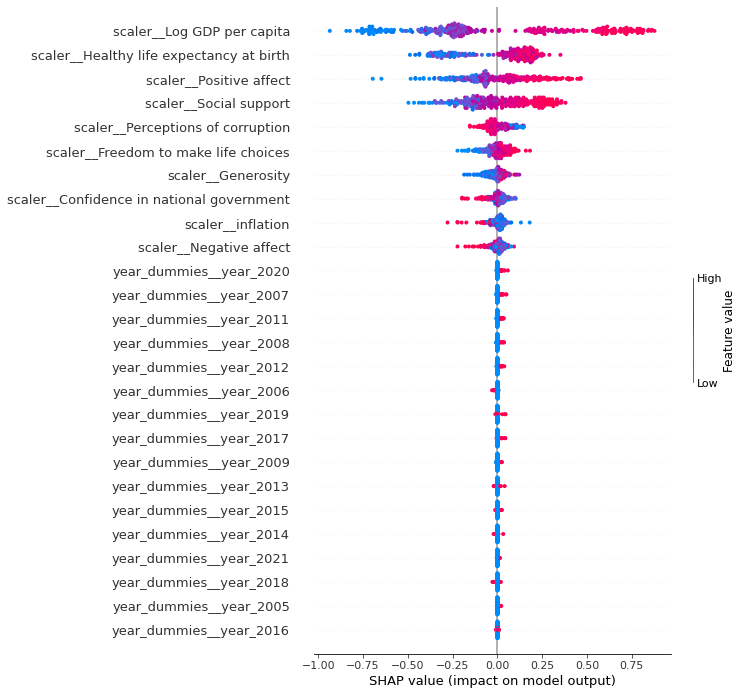

In [17]:
shap.summary_plot(shap_values, test_X, max_display=-1)

### GDP
In the previous notebook Pooled OLS, linear model, has been used with square terms of the GDP and its parameter estimate was significant. The XGBoost model here also confirms the nonlinearity with its estimation but seems like more than the second degree. A higher degree model could have fit here nicely. 

When the graph is divided using the feature value of 0, on the lower values of GDP, the curve is more flat, however where the GDP values are higher, it is more steep and linear. There higher GDP highly correlates with higher SHAP, unlike feature value between -1 and 0, where higher GDP contributes almost nothing to the happiness.

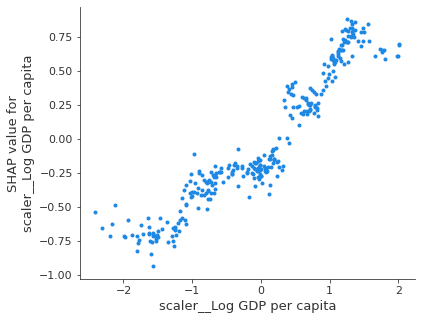

In [18]:
shap.dependence_plot("scaler__Log GDP per capita", shap_values, test_X, interaction_index=None)

### Healthy Life Expectancy at Birth
This is relatively simple graph with a catch. If the life expectancy is low, then the models predictions of happiness get lower. And the richier the country is, the higher the expectancy. But the effect on the models output after some point is way less. 

On the right top side of the graph, very high GDP countries and the ones with not very high GDP do get similar SHAP values even though there is a considerable difference in the life expectancy. This also causes an accumulation on the positive side for positive SHAP values, where the negative side is more dispersed. 

When looked vertically, the countries with same life expectancy on the right rop side of the graph, do get a different SHAP values by the model. Richer countries are with less SHAP and the poorer ones more. So the model predicts higher happiness for the poorer countries, once a certain threshold is passed, which is very surprising.

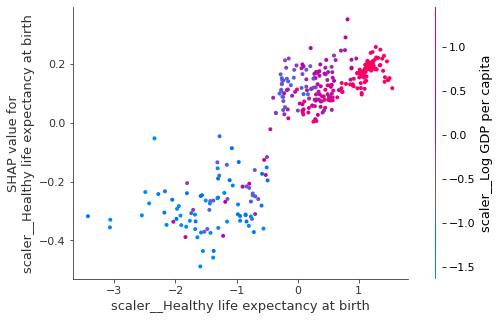

In [19]:
shap.dependence_plot("scaler__Healthy life expectancy at birth", shap_values, test_X)

### Perceptions of Corruptions
It is actually sad to see that the accumulation of the values are on a very high point. It is also the case for the full data, as we got to know from the short EDA in the previous notebook. There the mean is 0.74 and median 0.79.

As expected there is a clear negative relationship of corruption with the modeled happiness. But when the graph is divided into two parts using the red veritcal line, the story on the left side is a little different, there the negative relationship almost does not exist. So, the model considers like a negative linear when the feature values are high, but for the lower ones, other information is considered to decide on the impact of this feature.

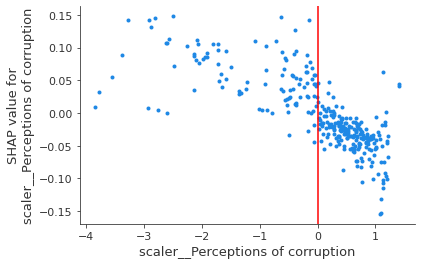

In [20]:
fig, ax = plt.subplots()
ax.axvline(x=0, color="red")
shap.dependence_plot(
    "scaler__Perceptions of corruption", shap_values, 
    test_X, interaction_index=None,
    ax=ax
)

### Year Effects
As expected, the model is not affected a lot by the years for the richer, more stable countries. The SHAP value of the high GDP countries are almost always closer to 0, than the ones with the lower GDP.

Another interesting point is the year 2020 SHAP values. The model predicts a high happiness for the year, even though discussions about lockdowns, social distances and vaccines were all introduced because of COVID-19 pandemic. To understand this affect, in the last plot the average happiness through years could be seen. There we see that until and including 2020, the average happiness score is increasing. This also agrees with the results of the model. 

On year 2005, the average score is very high, which is highly like because the countries who were able to afford this research were richer (so higher GDP), which is correlated to the happiness. Hence it could be a bias in the data.

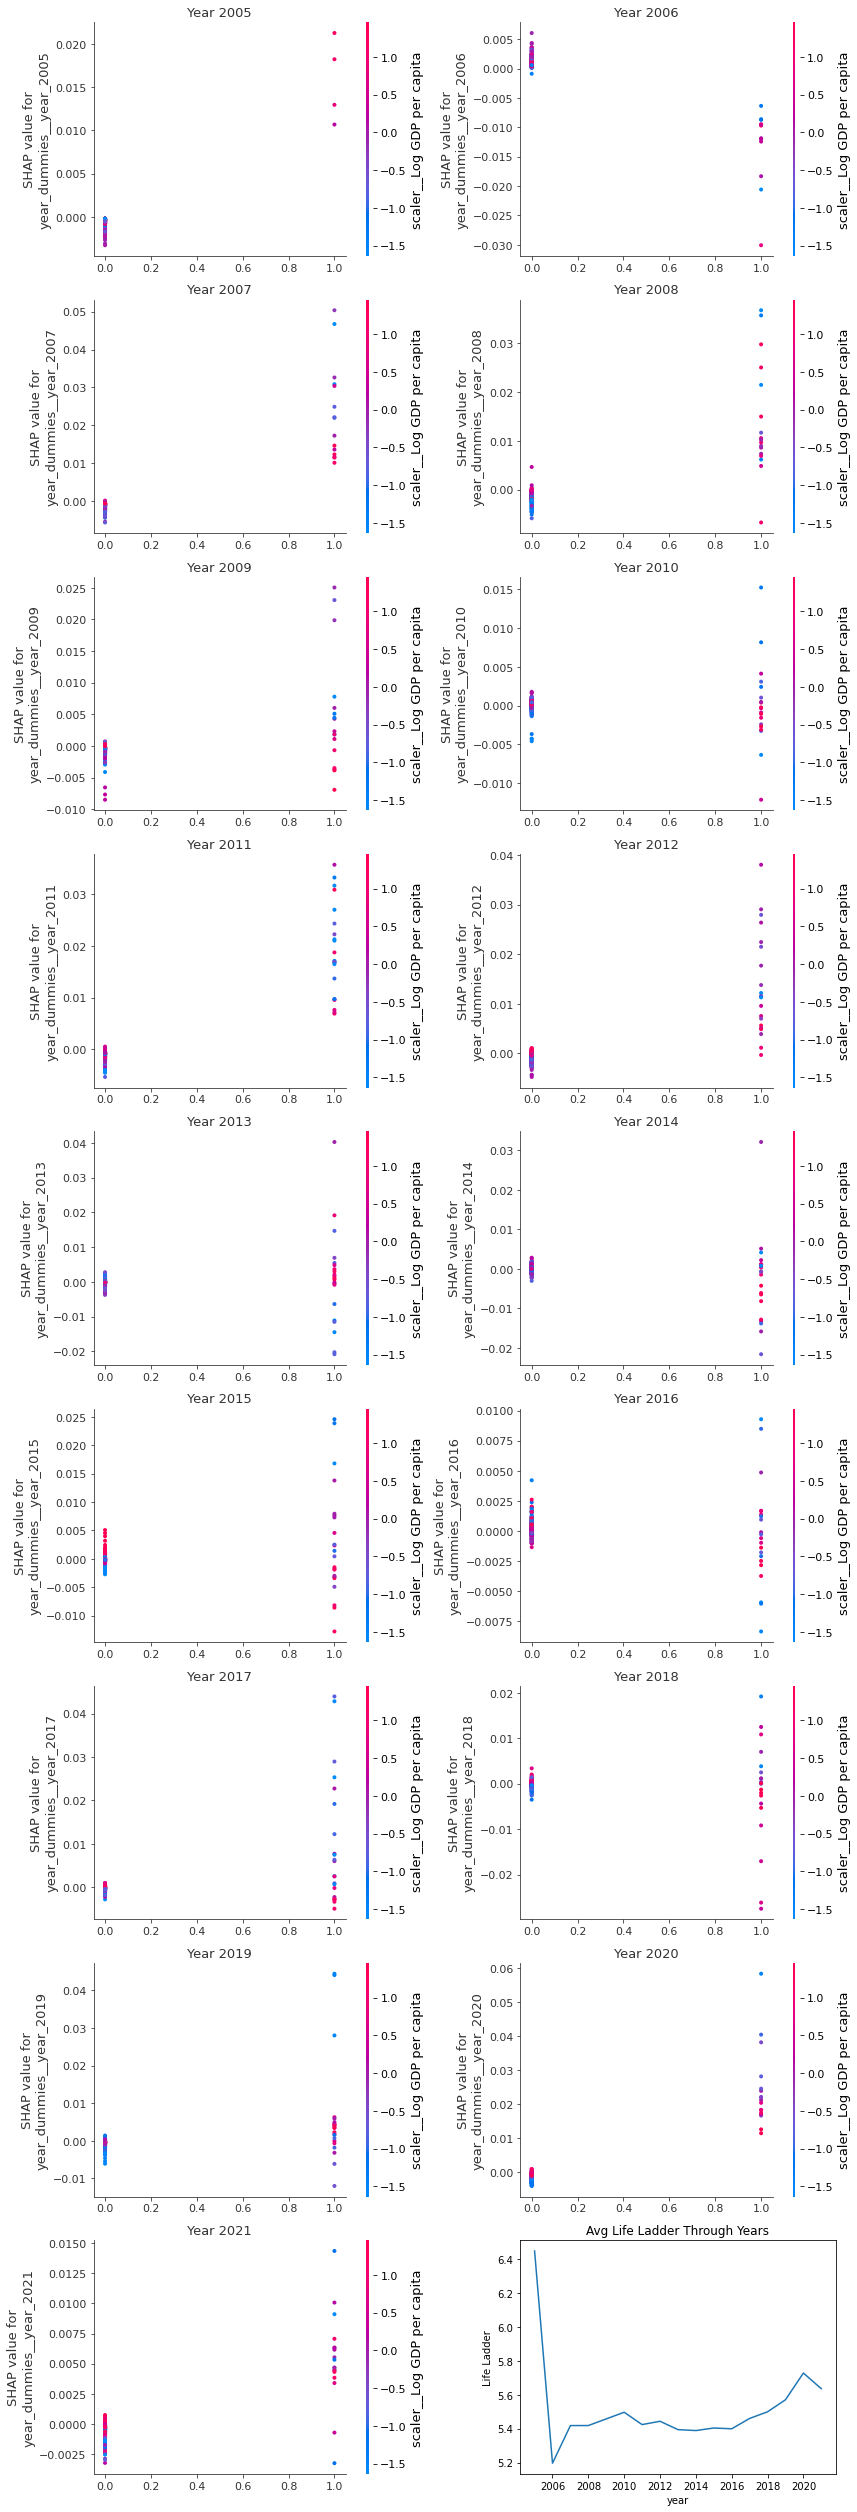

In [21]:
fig, axes = plt.subplots(9,2,figsize=(12,35), sharex=False, sharey=False)

for ax, year in zip(axes.flat, sorted(wh.year.unique())):    
    shap.dependence_plot(
        f"year_dummies__year_{year}", shap_values, 
        test_X, ax=ax, interaction_index="scaler__Log GDP per capita", 
        title=f"Year {year}",show=False
    )
    ax.set_xlabel("")
    
sns.lineplot(
    x="year", y="Life Ladder", 
    data=wh.groupby("year").agg({"Life Ladder":"mean"}),
    ax=axes[8,1]
)\
.set(title="Avg Life Ladder Through Years")

fig.tight_layout()
plt.show()

### Effect of Freedom to Make Life Choices
Here we have a clear linear relationship, increased freedom is modeled for increased happiness. Just to be aware, this effect is not one of the biggest, as seen in [summary](#Summary) plot.

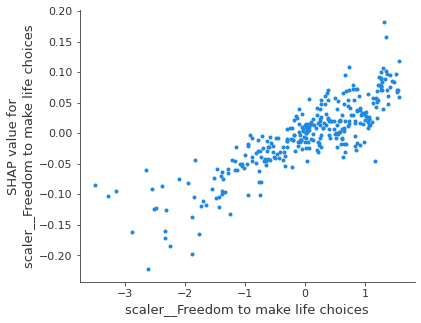

In [22]:
shap.dependence_plot(
    "scaler__Freedom to make life choices", shap_values, 
    test_X, interaction_index=None,
)

### Negative Affect
As mentioned above, the low values of negative affect does not have a large impact in the predictions, but when the feature value is high, the impact of it surges. However, there is another important outcome from the below plot. 

The largest interaction is with Healthy life expectancy at birth, from the EDA notebook we know that this has a positive correlation with GDP, so the below plot is colored by that. The interesting point is higher GDP countries form a steeper curve than the ones with lower GDP. On the left side of the plot, where the feature value is between -2 and 0, there is no obvious pattern regarding the GDPs. It can even be said that higher GDP gives higher SHAP, especially between -1 and 0. However, the story changes when we focus on higher values of negative affect. There, higher GDP would result a pattern of lower SHAP and a steeper curve. So it seems like the resilience of the higher GDP countries are modelled as lower than the lower GDP ones, for higher negative affect.

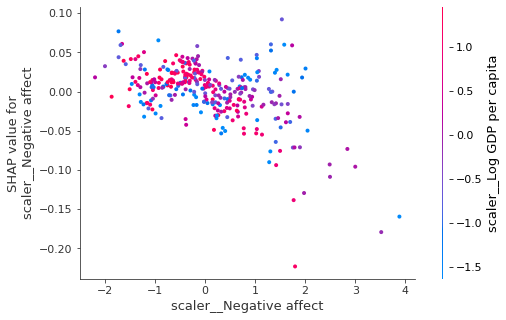

In [23]:
shap.dependence_plot(
    "scaler__Negative affect", shap_values, 
    test_X, interaction_index="scaler__Log GDP per capita"
)

### Positive Affect: Similar Result as in Negative Affect
Just like in the [negative affect](#Negative-Affect), the resillience of richer and poorer countries differ here.

When concentrated on the high GDP countries, we see that their slope remains almost constant in whole graph. This would mean high positive affect causes high SHAP, and low values low SHAP.

The low GDP countries form also a similar slope where the feature value is larger than 0. But very interestingly, they form a second degree curve where it is smaller than 0. It is seen that there the poorer countries are modeled with higher SHAP than the lower ones, and they are not impacted as heavily as the richer ones from the degreasing feature value. Hence the same result as in negative affect appears here, meaning the resillience of poorer countries is modeled higher.

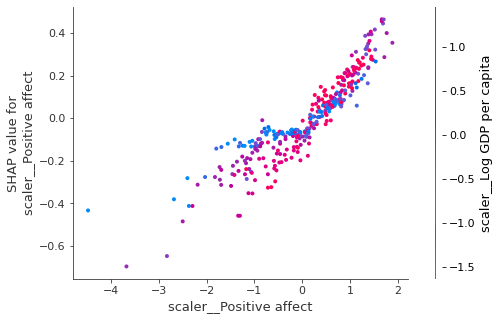

In [24]:
shap.dependence_plot(
    "scaler__Positive affect", shap_values, 
    test_X,
)

# Conclusion
In the previous research, the data from World Happiness Report 2022 has been taken and imputed using machine learning. This imputed data was used in this research, to check whether we can have a better fitting model than the one in the original report, which is giving us clues about the correlations of the happiness in the countries.

One important disdvantage of this study is the data being used. It is imputed from the rest of the data (excluding happiness score itself), which does not provide more information to the models, except being able to keep the non-null values instead of removing them.

On the other hand, unlike the original report, where only Pooled OLS, so a linear model, has been used, machine learning models were the main focus here in order to understand the relationships of happiness with other variables. In the end this has paid off, as the explained variance is 87% in this study, which is significantly higher compared to 77% in the original report.

The final model is an XGBoost model. Using the shapley values we were able to uncover the relationship of the features with the happiness score in the model. For example, higher GDP is associated with higher happiness but this relation does not stay constant throughout all the GDP values. Around the middle, coefficient of this relation would be close to 0. 

Also healthy life expectancy is a very important feature, where the countries with the same rather high life expenctancy are differentiated by the GDP. The one with the higher GDP contributes less happiness to the model. Such disadvantages to the higher GDP countries, regarding the corresponding shapley value for the feature, are also observed in negative and positive affect. Especially in positive affect, there is an obvious pattern, where the lower GDP countries do not decreasing in SHAP value, as the positive affect decreases, where higher GDP countries' SHAP value keeps decreasing in a linear relationship. 

Although freedom to make life choices does not have real high SHAP values, the clear positive relationship is there, confirming the expectations. When looked at the corruption, it is seen that very high feature values create a negative SHAP, with an obvious negative relationship. The relation vanishes on the lower feature values, though.

To conclude, the model explains the variance of happiness score rather well and it has interesting characteristics. I have learned a lot about the report and its data, and to be honest, I would love to have data which could explain causation of the happiness, not only correlation, as this was the most vital point, I had to keep reminding myself during analysis.